# Globalisation of Cinema: A Comparative Study of National Film Industries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px 
import geopandas as gpd 
from collections import Counter
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import math
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from src.utils.utils import *
from src.models.models import *
from src.utils.preprocessing import *

Imports needed for our project.

In [2]:
DOMESTIC_INTERNATIONAL_DATASET = "data/dataset_with_domestic_boxoffice.csv"
MOVIES_DATASET = "data/CMU_Other_dataset.csv"
POPULATION_DATASET = "data/world_population_2.csv"
GDP_DATASET = "data/world_gdp_2.csv"
CUMULATIVE_DATASET = "data/Cumulative_Movie_Production_Data.csv"

MAP_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

Datasets path we will use.

In [3]:
df_domestic_international = import_domestic_international_and_merge(DOMESTIC_INTERNATIONAL_DATASET, MOVIES_DATASET)
df_movies = pd.read_csv(MOVIES_DATASET)
df_population = import_and_preprocess_population(POPULATION_DATASET)
df_gdp = import_and_preprocess_gdp(GDP_DATASET)
df_cumulative = pd.read_csv(CUMULATIVE_DATASET)

df_map = gpd.read_file(MAP_URL)

We load all the needed data using pandas.

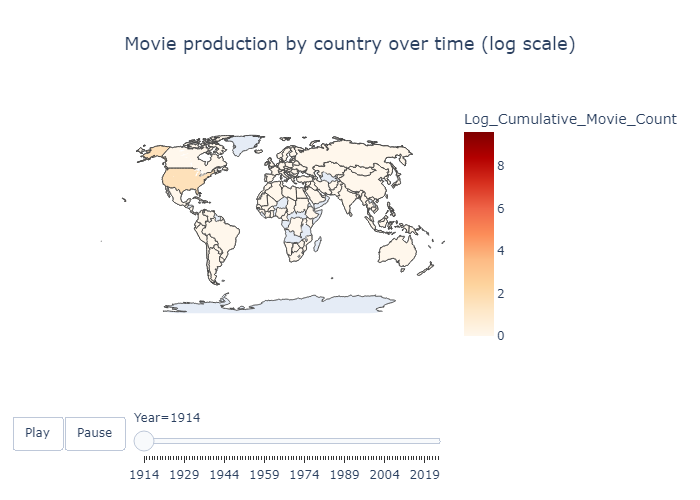

In [4]:
# Get the full range of years
min_year = int(df_cumulative['Year'].min())
max_year = int(df_cumulative['Year'].max())

# Create a complete DataFrame with all years and countries to fill missing entries
all_countries = df_cumulative['originLabel'].unique()
all_years = range(min_year, max_year + 1)
complete_index = pd.MultiIndex.from_product([all_countries, all_years], names=['originLabel', 'Year'])
df_complete = df_cumulative.set_index(['originLabel', 'Year']).reindex(complete_index, fill_value=None).reset_index()

# Forward-fill cumulative movie count for missing years
df_complete['Cumulative_Movie_Count'] = (
    df_complete.groupby('originLabel')['Cumulative_Movie_Count'].ffill().fillna(0)
)

# Ensure that missing cumulative counts are handled properly
df_complete['Cumulative_Movie_Count'] = df_complete['Cumulative_Movie_Count'].fillna(0)

# Apply a log transformation to cumulative movie count
df_complete['Log_Cumulative_Movie_Count'] = np.log1p(df_complete['Cumulative_Movie_Count'])

# Add event info for each year in df_complete
df_complete['Event'] = df_complete['Year'].apply(get_event_for_year)

# Create the animated choropleth map
fig = px.choropleth(
    df_complete,
    locations='originLabel',
    locationmode='country names',
    color='Log_Cumulative_Movie_Count',
    hover_name='originLabel',
    animation_frame='Year',
    projection='natural earth',
    title='Movie production by country over time (log scale)',
    color_continuous_scale='OrRd',
    range_color=[0, np.log1p(df_complete['Cumulative_Movie_Count'].max())]
)

# Add dynamic event annotation for each frame
for frame in fig.frames:
    year = int(frame.name)
    event_text = get_event_for_year(year)
    frame.layout = dict(
        annotations=[
            dict(
                x=0.5,
                y=-0.2,
                xref="paper",
                yref="paper",
                text=f"<b>{event_text}</b>",
                showarrow=False,
                font=dict(size=14)
            )
        ]
    )

# Add play and pause buttons
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(label='Play', method='animate', args=[None]),
                dict(label='Pause', method='animate', args=[[None], dict(frame=dict(duration=0, redraw=False), mode='immediate')])
            ]
        )
    ],
    geo=dict(showframe=False, showcoastlines=True),
    title_font_size=18,
    title_x=0.5
)

fig.show("png")

The map shows us that the U.S. basically invented the blockbuster game. Unsurprisingly, it was the OG of the movie industry, followed closely by Central Europe. France, of course, made its mark during the French New Wave – classic art house vibes. But the real game-changers showed up in the 90s, when India, China, and South America started to rise. They didn’t just join the global cinema party – they became major players, shaking up the entire industry.

C:\Users\qchap\AppData\Local\Temp\ipykernel_80600\3289057270.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



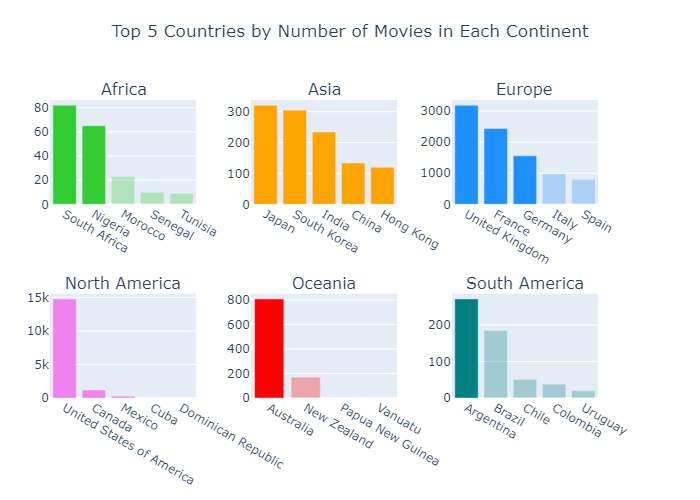

In [5]:
# Add continent column to the movies DataFrame
df_movies_copy = df_movies.replace("People's Republic of China", "China")
df_movies_copy['continent'] = df_movies_copy['originLabel'].apply(lambda x: map_continent(x, countries_by_continent))

# Group and count movies by continent and country
continent_country_counts = df_movies_copy.groupby(['continent', 'originLabel']).size().reset_index(name='count')

# Top 5 countries by number of movies within each continent
top_countries_per_continent = (
    continent_country_counts.groupby("continent")
    .apply(lambda x: x.nlargest(5, "count"))
    .reset_index(drop=True)
)

continents = top_countries_per_continent['continent'].unique()
n_continents = len(continents)

# Dynamically determine the grid size
n_cols = 3
n_rows = -(-n_continents // n_cols) 

# Add padding with spacing between subplots
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles=continents,
    horizontal_spacing=0.1,
    vertical_spacing=0.3
)

# Add bar charts to the grid for each continent
for idx, continent in enumerate(continents):
    row, col = divmod(idx, n_cols)  # Calculate grid position
    row += 1  # Adjust for 1-based indexing
    col += 1  # Adjust for 1-based indexing
    
    data = top_countries_per_continent[top_countries_per_continent['continent'] == continent]
    continent_color = continent_colors.get(continent, 'gray')
    
    for _, row_data in data.iterrows():
        country = row_data['originLabel']
        count = row_data['count']
        opacity = 1.0 if country in countries else 0.3
        
        fig.add_trace(
            go.Bar(
                x=[country],
                y=[count],
                name=continent,
                marker=dict(color=continent_color),
                opacity=opacity
            ),
            row=row, col=col
        )

# Update layout with padding and margin
fig.update_layout(
    title=dict(
        text="Top 5 Countries by Number of Movies in Each Continent",  
        x=0.5,      
        xanchor='center', 
        y=0.95 
    ),
    margin=dict(
        l=50,
        r=50,
        t=100,
        b=100
    ),
    showlegend=False
)

# Show the plot
fig.show("png")

To get a better sense of the global film landscape, we grouped countries by their continents to see how each contributes to the industry. The plot illustrates the influence of regions like Hollywood in North America, Bollywood in Asia, and other key players around the world. From this, we focused on the top contributors in each continent to ensure our data is as accurate and representative as possible.

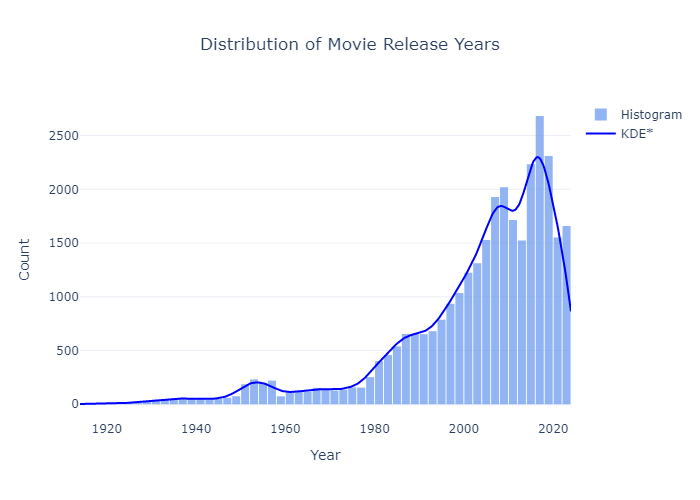

In [6]:
# Filter the Year column
year_data = df_movies["Year"].dropna()

# Compute KDE using Gaussian Kernel
kde = gaussian_kde(year_data)
x_vals = np.linspace(year_data.min(), year_data.max(), 500)
kde_vals = kde(x_vals) * len(year_data) * 2  # Scale KDE to match histogram count

# Define bin width for histogram
bin_width = 2

# Create figure
fig = go.Figure()

# Add histogram trace
fig.add_trace(go.Histogram(
    x=year_data,
    xbins=dict(
        start=year_data.min(),
        end=year_data.max(),
        size=bin_width
    ),
    marker=dict(color='rgba(100, 149, 237, 0.7)'),
    name="Histogram",
    hoverinfo="x+y"
))

# Add KDE line trace
fig.add_trace(go.Scatter(
    x=x_vals,
    y=kde_vals,
    mode="lines",
    line=dict(color="blue", width=2),
    name="KDE*"
))

fig.update_layout(
    title=dict(
        text="Distribution of Movie Release Years",
        x=0.5,
        xanchor='center'
    ),
    xaxis_title="Year",
    yaxis_title="Count",
    bargap=0.1,
    template="plotly_white"
)

# Show the plot
fig.show("png")

Looking at the distribution of movie release years is interesting in order to learn more about the data we use. It will also be important later when using the dataset starting from 1960 because as we can see, it does not change much to the interpretation to keep only the movies from 1960 and after for our analysis.

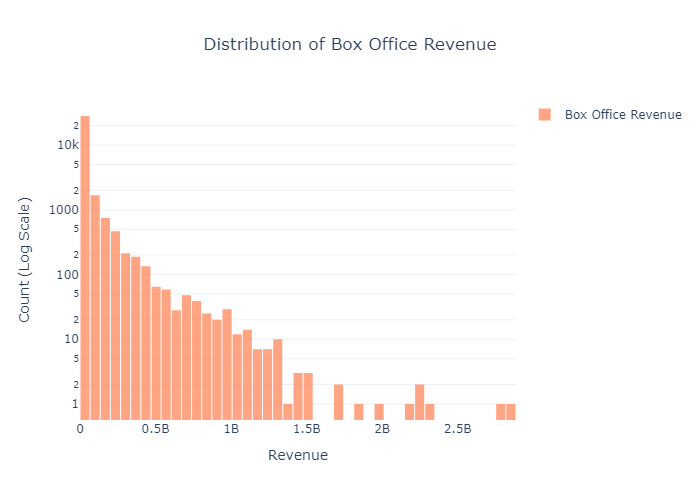

In [7]:
# Filter the worldwide revenue column
revenue_data = df_movies["worldwide"].dropna()

# Define bin size for histogram
num_bins = 50  # Define the number of bins
bin_size = (revenue_data.max() - revenue_data.min()) / num_bins

# Create the figure
fig = go.Figure()

# Add histogram trace
fig.add_trace(go.Histogram(
    x=revenue_data,
    xbins=dict(
        start=revenue_data.min(),
        end=revenue_data.max(),
        size=bin_size
    ),
    marker=dict(color='rgba(255, 127, 80, 0.7)'),
    name="Box Office Revenue"
))

# Update layout
fig.update_layout(
    title=dict(
        text="Distribution of Box Office Revenue",
        x=0.5,
        xanchor='center'
    ),
    xaxis_title="Revenue",
    yaxis_title="Count (Log Scale)",
    yaxis_type="log",
    bargap=0.1,
    template="plotly_white",
    showlegend=True
)

# Show the plot
fig.show("png")

We can see that the distribution of box office revenue follows a Pareto distribution. That is why we will chose a Kolgomorov - Smirnov test later.

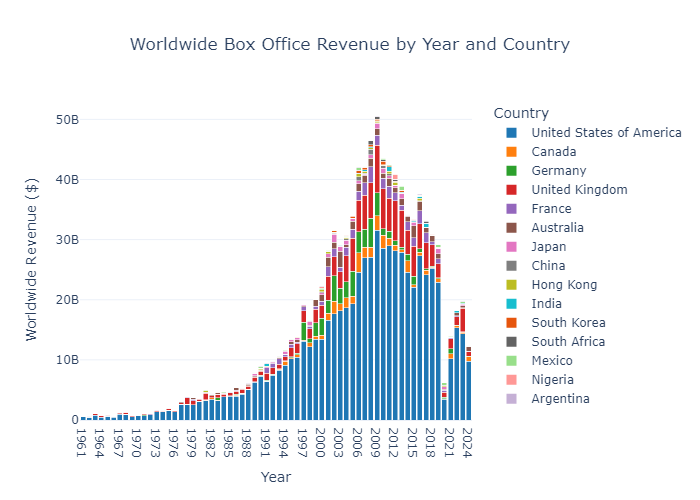

In [8]:
# Filter the dataset for the specified countries, non-null worldwide revenue, and Year after 1960
filtered_data = df_movies[df_movies['originLabel'].isin(countries) & df_movies['worldwide'].notnull() & (df_movies['Year'] > 1960)]

# Group data by Year and originLabel and sum the worldwide revenue
aggregated_data = filtered_data.groupby(['Year', 'originLabel'])['worldwide'].sum().reset_index()

# Ensure all specified countries are represented in the legend, even if they have no data
for country in countries:
    if country not in aggregated_data['originLabel'].unique():
        missing_years = pd.DataFrame({
            "Year": pd.Series(aggregated_data["Year"].unique()),
            "originLabel": country,
            "worldwide": 0
        })
        aggregated_data = pd.concat([aggregated_data, missing_years], ignore_index=True)

# Sort the aggregated data to ensure consistent order in the plot
aggregated_data = aggregated_data.sort_values(by=["Year", "originLabel"])

# Create the figure
fig = go.Figure()

# Add a trace for each country
for country in countries:
    country_data = aggregated_data[aggregated_data['originLabel'] == country]
    fig.add_trace(go.Bar(
        x=country_data['Year'],
        y=country_data['worldwide'],
        name=country,
        marker_color=colormap_boxoffice[country],
        hovertemplate=f"<b>{country}</b><br>Year: %{{x}}<br>Worldwide: $%{{y:,.0f}}<extra></extra>"
    ))

# Update layout
fig.update_layout(
    title=dict(
        text="Worldwide Box Office Revenue by Year and Country",
        x=0.5,
        xanchor="center"
    ),
    xaxis_title="Year",
    yaxis_title="Worldwide Revenue ($)",
    barmode="stack",
    template="plotly_white",
    legend_title="Country",
    xaxis=dict(type="category"), 
    legend=dict(
        traceorder="normal",
        itemsizing="constant", 
        orientation="v",
        x=1.05,
        y=1
    )
)

# Show the plot
fig.show("png")

This plot shows the repartition of worlwide boxoffice revenue by year and by country. By looking at this plot we can better understand the biases we will certainly face during our project.

In [9]:
# Preprocess for further analysis
df_movies = df_movies.dropna(subset=['worldwide', 'Year'])
df_movies = df_movies[df_movies['originLabel'].isin(countries)]
df_movies['Year'] = pd.to_numeric(df_movies['Year'], errors='coerce')

# Keep only years after 1960 in a copy
new_df_movies = df_movies[df_movies['Year'] >= 1960]

C:\Users\qchap\AppData\Local\Temp\ipykernel_80600\4087439005.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\qchap\AppData\Local\Temp\ipykernel_80600\4087439005.py:42: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



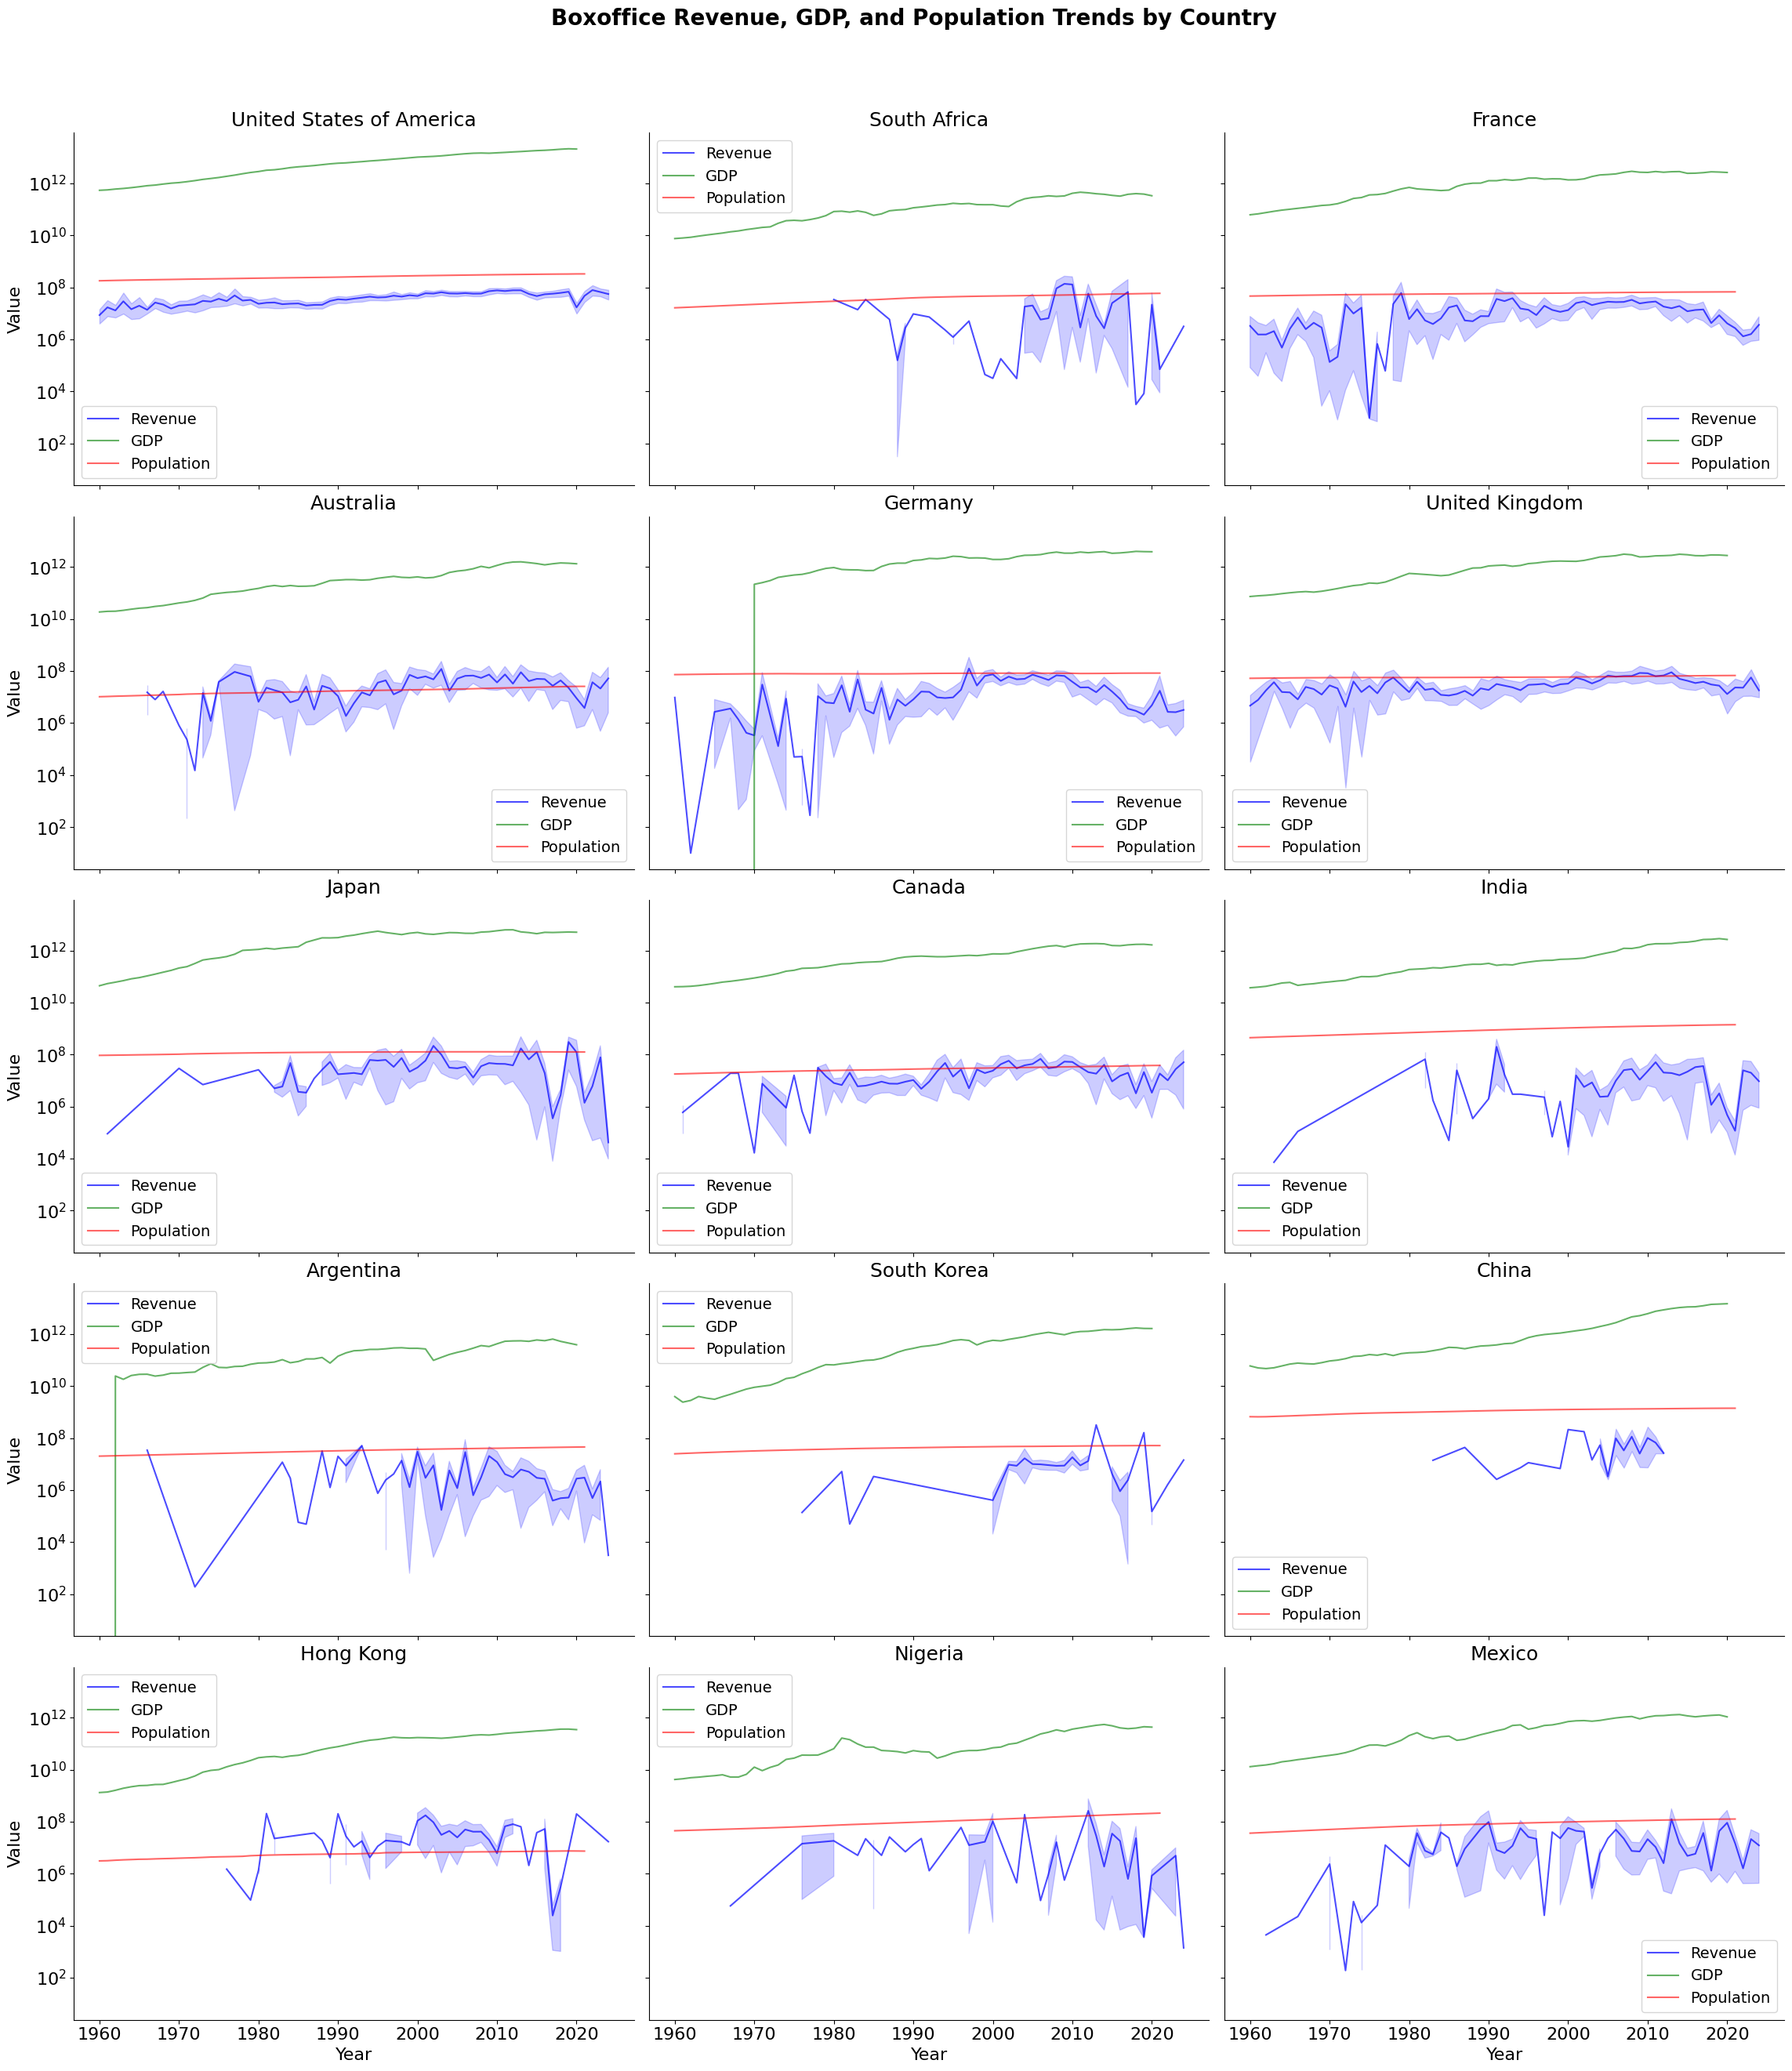

In [10]:
# Melt GDP and Population DataFrames to long format for consistency
df_gdp_melted = df_gdp.melt(id_vars=['originLabel'], var_name='Year', value_name='GDP')
df_population_melted = df_population.melt(id_vars=['originLabel'], var_name='Year', value_name='Population')

# Ensure 'Year' is numeric for all datasets
new_df_movies['Year'] = pd.to_numeric(new_df_movies['Year'], errors='coerce')
df_gdp_melted['Year'] = pd.to_numeric(df_gdp_melted['Year'], errors='coerce')
df_population_melted['Year'] = pd.to_numeric(df_population_melted['Year'], errors='coerce')

# Initialize a FacetGrid with one plot per country
g = sns.FacetGrid(new_df_movies, col='originLabel', col_wrap=3, height=5, aspect=1.5)

# Plot Worldwide Revenue
g.map(sns.lineplot, 'Year', 'worldwide', alpha=0.7, label='Revenue', color='blue')

# Overlay GDP
for ax, country in zip(g.axes.flatten(), g.col_names):
    df_country_gdp = df_gdp_melted[df_gdp_melted['originLabel'] == country]
    sns.lineplot(x='Year', y='GDP', data=df_country_gdp, ax=ax, color='green', label='GDP', alpha=0.6)

# Overlay Population
for ax, country in zip(g.axes.flatten(), g.col_names):
    df_country_pop = df_population_melted[df_population_melted['originLabel'] == country]
    sns.lineplot(x='Year', y='Population', data=df_country_pop, ax=ax, color='red', label='Population', alpha=0.6)

# Customize the appearance
g.set_titles(col_template="{col_name}", size=18)
g.set_axis_labels('Year', 'Value', fontsize=16)

for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=16)

g.set(yscale="log")

for ax in g.axes.flatten():
    ax.legend(fontsize=14) 

g.fig.suptitle("Boxoffice Revenue, GDP, and Population Trends by Country", 
               fontsize=20, weight='bold', y=1.05)

# Show the plot
g.fig.show()

The first graph shows how movie revenue, GDP, and population evolved over time across 15 countries. GDP (in green) tends to follow a steady upward climb, while population (in red) increases at a slower and more predictable rate.<br>
Hollywood, for instance, exploded in the mid-20th century when the U.S. economy was booming. Hollywood, for instance, exploded in the mid-20th century when the U.S. economy was booming. A flourishing economy probably enabled American producers to create more films, and with higher production standards. Meanwhile, South Africa and Argentina display far more volatility, with sharp drops and rises, due to a potential economic instability affecting their film industries. On the other hand, India and Nigeria showcase more recent spikes in revenue, reflecting the rapid rise of Bollywood and Nollywood in the global film scene. So yes, GDP growth often props up film industries, but not always predictably.

In [11]:
# Group by 'originLabel' and 'Year', then calculate the mean of 'worldwide'
movies_grouped= new_df_movies.groupby(['originLabel', 'Year'])['worldwide'].sum().reset_index()

# Rename the column for clarity
movies_grouped.rename(columns={'worldwide': 'TotalWorldwideRevenue'}, inplace=True)

# Merge datasets by country and year
merged_data = pd.merge(movies_grouped, df_gdp_melted, on=['originLabel', 'Year'], how='inner')
merged_data = pd.merge(merged_data, df_population_melted, on=['originLabel', 'Year'], how='inner')

correlation_results = spearman_corr(countries, merged_data)

# Display results
print(correlation_results.to_string(index=False))

                 Country  Movies - GDP  Movies - Population
United States of America      0.941883             0.941248
                  Canada      0.808990             0.794647
                 Germany      0.768300             0.771360
          United Kingdom      0.919355             0.903966
                  France      0.878689             0.868482
               Australia      0.793563             0.807906
                   Japan      0.573392             0.699286
                   China      0.640351             0.640351
               Hong Kong      0.307729             0.304410
                   India      0.520754             0.537615
             South Korea      0.232072             0.204969
            South Africa      0.288134             0.249622
                  Mexico      0.624186             0.630482
                 Nigeria      0.126210             0.083871
               Argentina      0.412281             0.348981


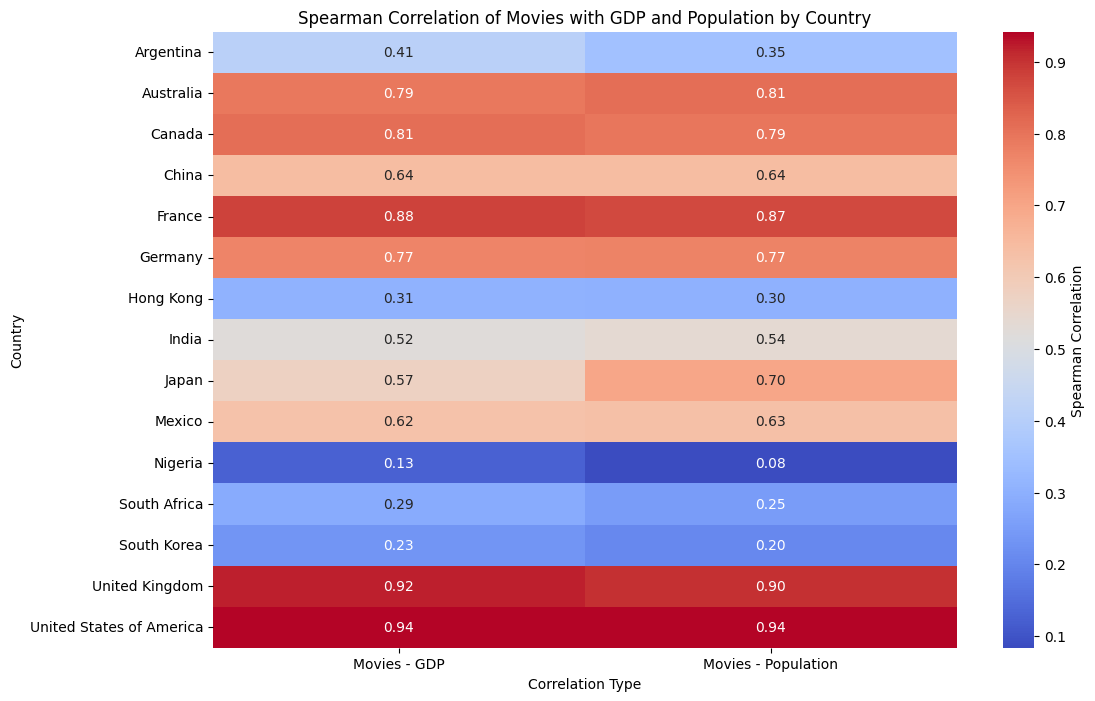

In [12]:
# Reshape the data for heatmap
heatmap_data = correlation_results.melt(id_vars="Country", var_name="Correlation_Type", value_name="Value")

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    heatmap_data.pivot_table(index="Country", columns="Correlation_Type", values="Value"),
    annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Spearman Correlation'}
)
plt.title("Spearman Correlation of Movies with GDP and Population by Country")
plt.ylabel("Country")
plt.xlabel("Correlation Type")
plt.show()

We can see that in countries like the USA, UK, and France, GDP and population strongly correlate with movie revenue.<br>
This suggests that in well-established film industries, economic power and the size of the audience are key factors driving success.<br>
On the other hand, emerging markets such as India and Mexico display moderate (positive) correlations. <br>
This could suggest that less developed film industries may be influenced by additional cultural, regional, or market-specific factors.<br>
Countries with near-zero correlations (for example Nigeria) likely face market challenges that limit the film industry’s connection to GDP and population. <br>
Finally, we can also observe some surprising results:<br>
-For Hong Kong, the low correlation values (0.31 for GDP and 0.30 for population) could suggest that the local film industry faces intense competition from neighboring regions, such as Mainland China, South Korea, and Japan. Despite its historical significance in cinema, the market may be saturated or heavily influenced by external content, limiting the direct impact of GDP and population size on domestic film revenue.

R² score for United States of America: 0.8939164425734609
R² score for Canada: 0.576423345727372
R² score for Germany: 0.3706574426072654
R² score for United Kingdom: 0.8135495283043157
R² score for France: 0.725738407396333
R² score for Australia: 0.5166095887673511
R² score for Japan: 0.42192578825812677
R² score for China: 0.5202173966460892
R² score for Hong Kong: 0.3426077353984127
R² score for India: 0.35636325034570837
R² score for South Korea: 0.5978292230191867
R² score for South Africa: 0.25815175243012656
R² score for Mexico: 0.27323641468185256
R² score for Nigeria: 0.1418514276066568
R² score for Argentina: 0.10151086845557045


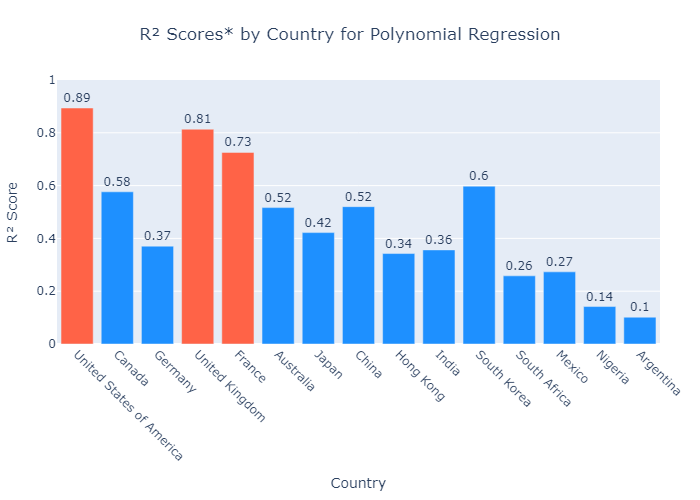

In [13]:
# Calculate the number of rows and columns for subplots
n_countries = len(countries)
n_cols = 4 
n_rows = math.ceil(n_countries / n_cols)

r2_scores = lin_reg(countries, merged_data)

# Prepare data
r2_scores_df = pd.DataFrame(r2_scores)

# Define bar colors: red for R² > 0.6, blue otherwise
colors = ['tomato' if r2 > 0.6 else 'dodgerblue' for r2 in r2_scores_df['R² Score']]

# Create the plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=r2_scores_df["Country"],
    y=r2_scores_df["R² Score"],
    marker=dict(color=colors),  
    text=r2_scores_df["R² Score"].round(2), 
    textposition='outside'
))

# Update layout for better readability
fig.update_layout(
    title=dict(
        text="R² Scores* by Country for Polynomial Regression",
        x=0.5,
        xanchor="center"
    ),
    xaxis=dict(
        title="Country",
        tickangle=45, 
    ),
    yaxis=dict(
        title="R² Score",
        range=[0, 1]
    ),
    margin=dict(l=40, r=40, t=80, b=150)
)

# Show the plot
fig.show("png")

We then try to predict the national box office revenue (for each of our countries) trends over time using GDP and population data. <br>
We can observe that GDP and population data predict revenues well in developed markets like the United States (R² = 0.89) and the United Kingdom (R² = 0.81), but fail in emerging markets like Nigeria (R² = 0.14) and Argentina (R² = 0.10). This supports our previous assumptions stated when analyzing the Spearman correlations between national box office revenue and GDP resp. population.

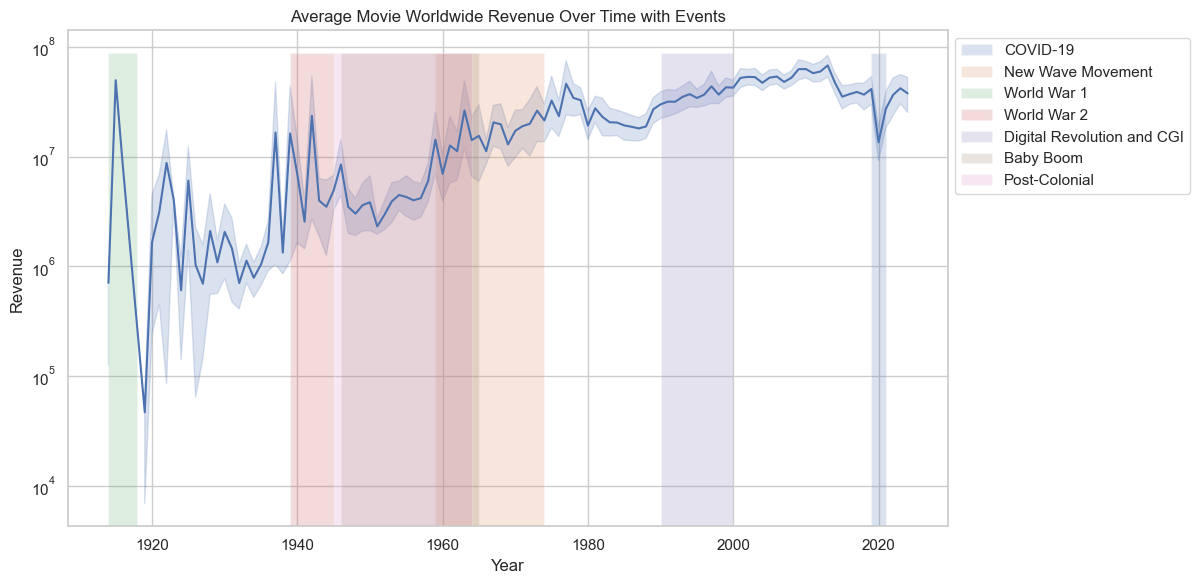

In [14]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df_movies, x='Year', y='worldwide',ax=ax)

original_ylim = ax.get_ylim()
for _, row in events_df.iterrows():
    ax.fill_betweenx(
        original_ylim, 
        row['StartYear'], row['EndYear'],
        alpha=0.2, label=row['Event']
    )

# Show the plot
ax.set_title('Average Movie Worldwide Revenue Over Time with Events')
ax.set_xlabel('Year')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.yscale("log")

We plot the mean revenue generated by a movie (woldwide), by year. 
We can see that on the long term, there is a general increase in worldwide mean movie revenue.
This could be due to various factors such as technological advancements or population growth.
For years prior to 1950, we can see that there are high variations in the worldwide mean movie revenue, which could be due to lack of data or economic and global events like World War I, the Great Depression, and World War II influencing movie production and demand.

Starting in the 1950s, the revenue trends stabilize and gradually rise, which could correspond to the post-war economic boom and the rise of television.

An increase in mean movie revenue is observed from the 1980s onwards and revenue levels appear to stabilize around the 2000s at higher values, although there is still some year-to-year variability.

However, we can notice a clear drop in revenue around 2020, which is likely due to the COVID-19 pandemic. The closure of theaters worldwide could have significantly impacted box office revenue during this period.

Therefore, we would like to test if the distribution of worldwide box office revenues for movies released pre-Covid (2017-2019) has significantly changed versus post-Covid (2020-2022) for each country in our list.

c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ADA\project\env\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



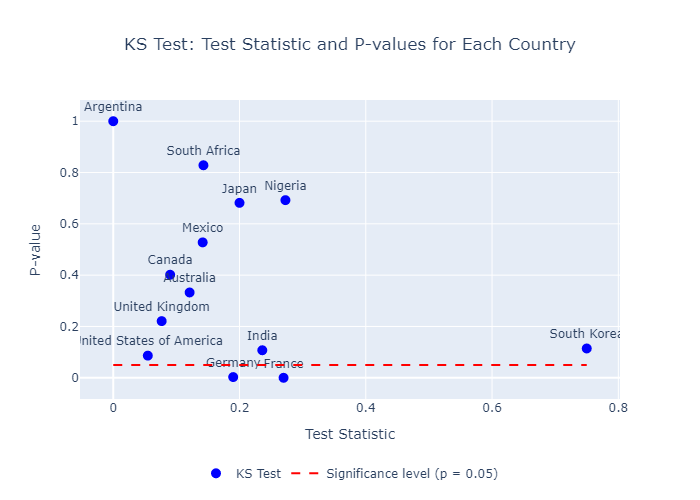

In [15]:
# KS-test
data = ks_test(countries, new_df_movies)

# Create the plot
fig = go.Figure()

# Add scatter plot for test statistics and p-values
fig.add_trace(go.Scatter(
    x=data['Test Statistic'],
    y=data['P-value'],
    mode='markers+text',
    text=data['Country'],
    textposition='top center',
    marker=dict(color='blue', size=10),
    name='KS Test'
))

# Add a horizontal line for the significance threshold
fig.add_trace(go.Scatter(
    x=[min(data['Test Statistic']), max(data['Test Statistic'])],
    y=[0.05, 0.05],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Significance level (p = 0.05)'
))

# Update layout
fig.update_layout(
    title={'text': 'KS Test: Test Statistic and P-values for Each Country', 'x': 0.5},
    xaxis_title='Test Statistic',
    yaxis_title='P-value',
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2)
)

# Show the plot
fig.show("png")

To do this, we perform a KS test (Kolgomorov - Smirnov test) where we compare whether the worldwide box office revenue distribution for movies post-Covid differs significantly from the pre-Covid distribution for each country. Specifically, the alternative hypothesis (alternative='less') checks if post-Covid revenues are stochastically smaller than pre-Covid revenues. <br>
A significant p-value (<0.05) would suggest that the worldwide revenues post-Covid are lower than pre-Covid for the given country whereas if the p-value is higher than this threshold, we fail to reject the null hypothesis, meaning there is no evidence that revenues have decreased post-Covid compared to pre-Covid.

Germany and France show significant shifts in their revenue distributions (p < 0.05), suggesting Covid had a measurable impact on their box office performance. <br>
However, most other countries with already well developed movie industries(including USA, UK, Canada, Japan, Australia) show no significant difference (p > 0.05), indicating consistent box office trends pre- and post-Covid. <br>
Countries like South Korea and India exhibit moderate to high test statistics but lack statistical significance, likely due to the lack of data unaccounted variability.<br>
Similarly, we obtain very low test statistics with high p value in the case of countries like Nigeria and Argentina which is also likely caused by the lack of data. <br>
For countries with well developed movie industries, the results of our test seem coherent : 
- In the case of France and Germany we observe that those countries show significant shifts in revenue distributions post-Covid, which is plausible given their strict lockdown measures and cultural preferences for local cinema. Indeed, those countries and especially France are known to have robust local film industries, and the pandemic might have disrupted its production and audience engagement.  Moreover, European countries also faced prolonged restrictions, which may have delayed box office recovery.<br>
- In the case of USA, Australia, UK, Canada, ect where we observed no significant difference in revenue distributions pre and post Covid, it is quite coherent since these markets often rely heavily on Hollywood blockbusters, which adapted quickly post-Covid (for example they had simultaneous streaming releases and also the big-budget productions are resuming faster). The moderate test statistics and non-significant p-values align with their ability to recover quickly compared to other markets. <br>
- In the case of Japan, it had relatively successful Covid-19 management early on and reopened cinemas sooner than other regions which could explain their national box office revenue stability.<br>



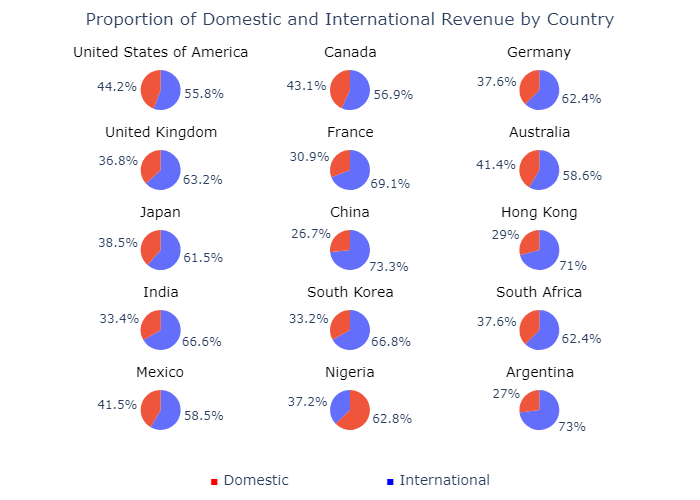

In [16]:
# Create the figure
fig = go.Figure()

# Set the grid size
rows = 5
cols = 3

# Plot pie charts for each country
for idx, country in enumerate(countries):
    country_data = df_domestic_international[df_domestic_international['originLabel'] == country]
    
    tot = country_data['domestic'].sum() + country_data['international'].sum()

    domestic_size = country_data['domestic'].sum() / tot
    international_size = country_data['international'].sum() / tot
    
    # Define labels and sizes for the pie chart
    labels = ['Domestic', 'International']
    sizes = [domestic_size, international_size]
    
    # Calculate row and column index for pie chart position
    row = idx // cols
    col = idx % cols
    
    # Add pie chart as a trace with specific positioning
    fig.add_trace(go.Pie(
        labels=labels, 
        values=sizes, 
        name=country, 
        hoverinfo='label+percent',
        hole=0,
        domain=dict(
            x=[col / cols + 0.05, (col + 1) / cols - 0.05],
            y=[(rows - row - 1) / rows + 0.05, (rows - row) / rows - 0.05]
        )
    ))

    # Add the country name above each pie chart
    fig.add_annotation(
        x=(col + 0.5) / cols,
        y=(rows - row) / rows - 0.03,
        text=country,
        showarrow=False,
        font=dict(size=14, color="black"),
        align="center",
        xanchor="center",
        yanchor="bottom"
    )

# Add annotations for red (Domestic) and blue (International) labels
fig.add_annotation(
    x=0.25,
    y=-0.1,
    text='<span style="color:red;">■</span> Domestic',
    showarrow=False,
    font=dict(size=14),
    align="center"
)

fig.add_annotation(
    x=0.75, 
    y=-0.1,
    text='<span style="color:blue;">■</span> International',
    showarrow=False,
    font=dict(size=14),
    align="center"
)

# Update layout for better visualization
fig.update_layout(
    title="Proportion of Domestic and International Revenue by Country",
    title_x=0.5,
    grid=dict(rows=rows, columns=cols),
    showlegend=False, 
    template="plotly_white",
    margin=dict(l=15, r=15, t=50, b=50) 
)

# Show the plot
fig.show("png")

The plot shows us the proportion of domestic and international box office revenues for our chosen 15 countries. One thing is sure, Nigerian viewers have a preference for domestic Nollywood movies. But for India, the results were not exactly as one could expect. One could think that India's Bollywood films would be more visible on the local scale, with their characteristic dramas, romances, and musicals. However, our dataset did not provide such evidence. This may be due to a significant lack of representation of Indian movies in our dataset. We also see that english-speaking countries tend to have a more balanced domestic-to-international ratio. This could mainly be related to the shared language, which allows both domestic films and international productions, particularly from Hollywood, to reach a wider audience all around the world. In Argentina and Hong Kong, the high preference for international films could result from competition with neighboring countries' film markets. People might prefer movies from bigger, more well-known industries.

c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ADA\project\src\utils\preprocessing.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



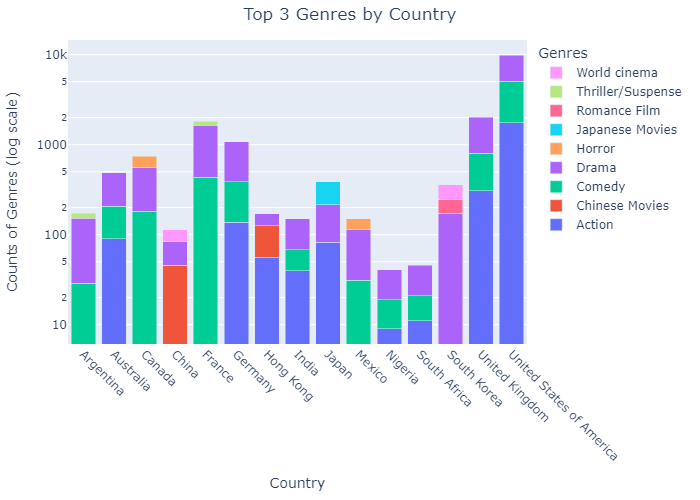

In [17]:
# Preprocess the data for the plot
df_movies_preprocessed = preprocess_movies_for_genres_analysis(df_movies)

# Aggregate the data
aggregated_data = df_movies_preprocessed.groupby(["originLabel", "Genre"])["counts"].sum().reset_index()

# Remove genres with zero counts
aggregated_data = aggregated_data[aggregated_data["counts"] > 0]

# Get the top 3 genres for each region
top_3_genres_per_region = (
    aggregated_data
    .sort_values(["originLabel", "counts"], ascending=[True, False])
    .groupby("originLabel")
    .head(3)
)

# Pivot the data for stacked bar chart
pivot_data = top_3_genres_per_region.pivot(index="originLabel", columns="Genre", values="counts")

# Drop any genres (columns) where all values are NaN (filtered zero-count genres)
pivot_data = pivot_data.dropna(axis=1, how="all")

# Create the figure
fig = go.Figure()

# Add each broad genre as a separate trace to the stacked bar chart
for genre in pivot_data.columns:
    fig.add_trace(
        go.Bar(
            x=pivot_data.index, 
            y=pivot_data[genre], 
            name=genre
        )
    )

# Customize the layout
fig.update_layout(
    title=dict(
        text="Top 3 Genres by Country",
        x=0.5,
        xanchor='center'
    ),
    xaxis_title="Country",
    yaxis_title="Counts of Genres (log scale)",
    barmode="stack",
    yaxis=dict(type="log"),
    legend_title="Genres",
    xaxis=dict(tickangle=45),
    margin=dict(l=20, r=20, t=40, b=20),
    hovermode="x unified" 
)

# Show the plot
fig.show("png")

This plot illustrates the top three movie genres for each country, with the counts displayed on a logarithmic scale to show differences more clearly. Action and Comedy dominate as the top genres. In every country except China, Hong Kong, Japan, and South Korea, Action movies make up the majority of the top three genres. These countries however, tend to have a preference for locally produced movies, as we see for the Chinese Movies in China and Japanese Movies in Japan. As in the previous graph, we found it intriguing that Indian movies did not rank among the top for India. However, as mentioned earlier, this could be attributed to a lack of sufficient data. We can also observe the significant presence of Drama movies in the top genres across all countries. However, it's important to consider how this genre is defined, as biases may arise. What qualifies as a Drama in one country might not align with the definition in another, and vice versa.

c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ADA\project\src\utils\preprocessing.py:101: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ADA\project\src\utils\preprocessing.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\qchap\OneDrive\Donnees\EPFL\MA1\ADA\project\src\utils\preprocessing.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

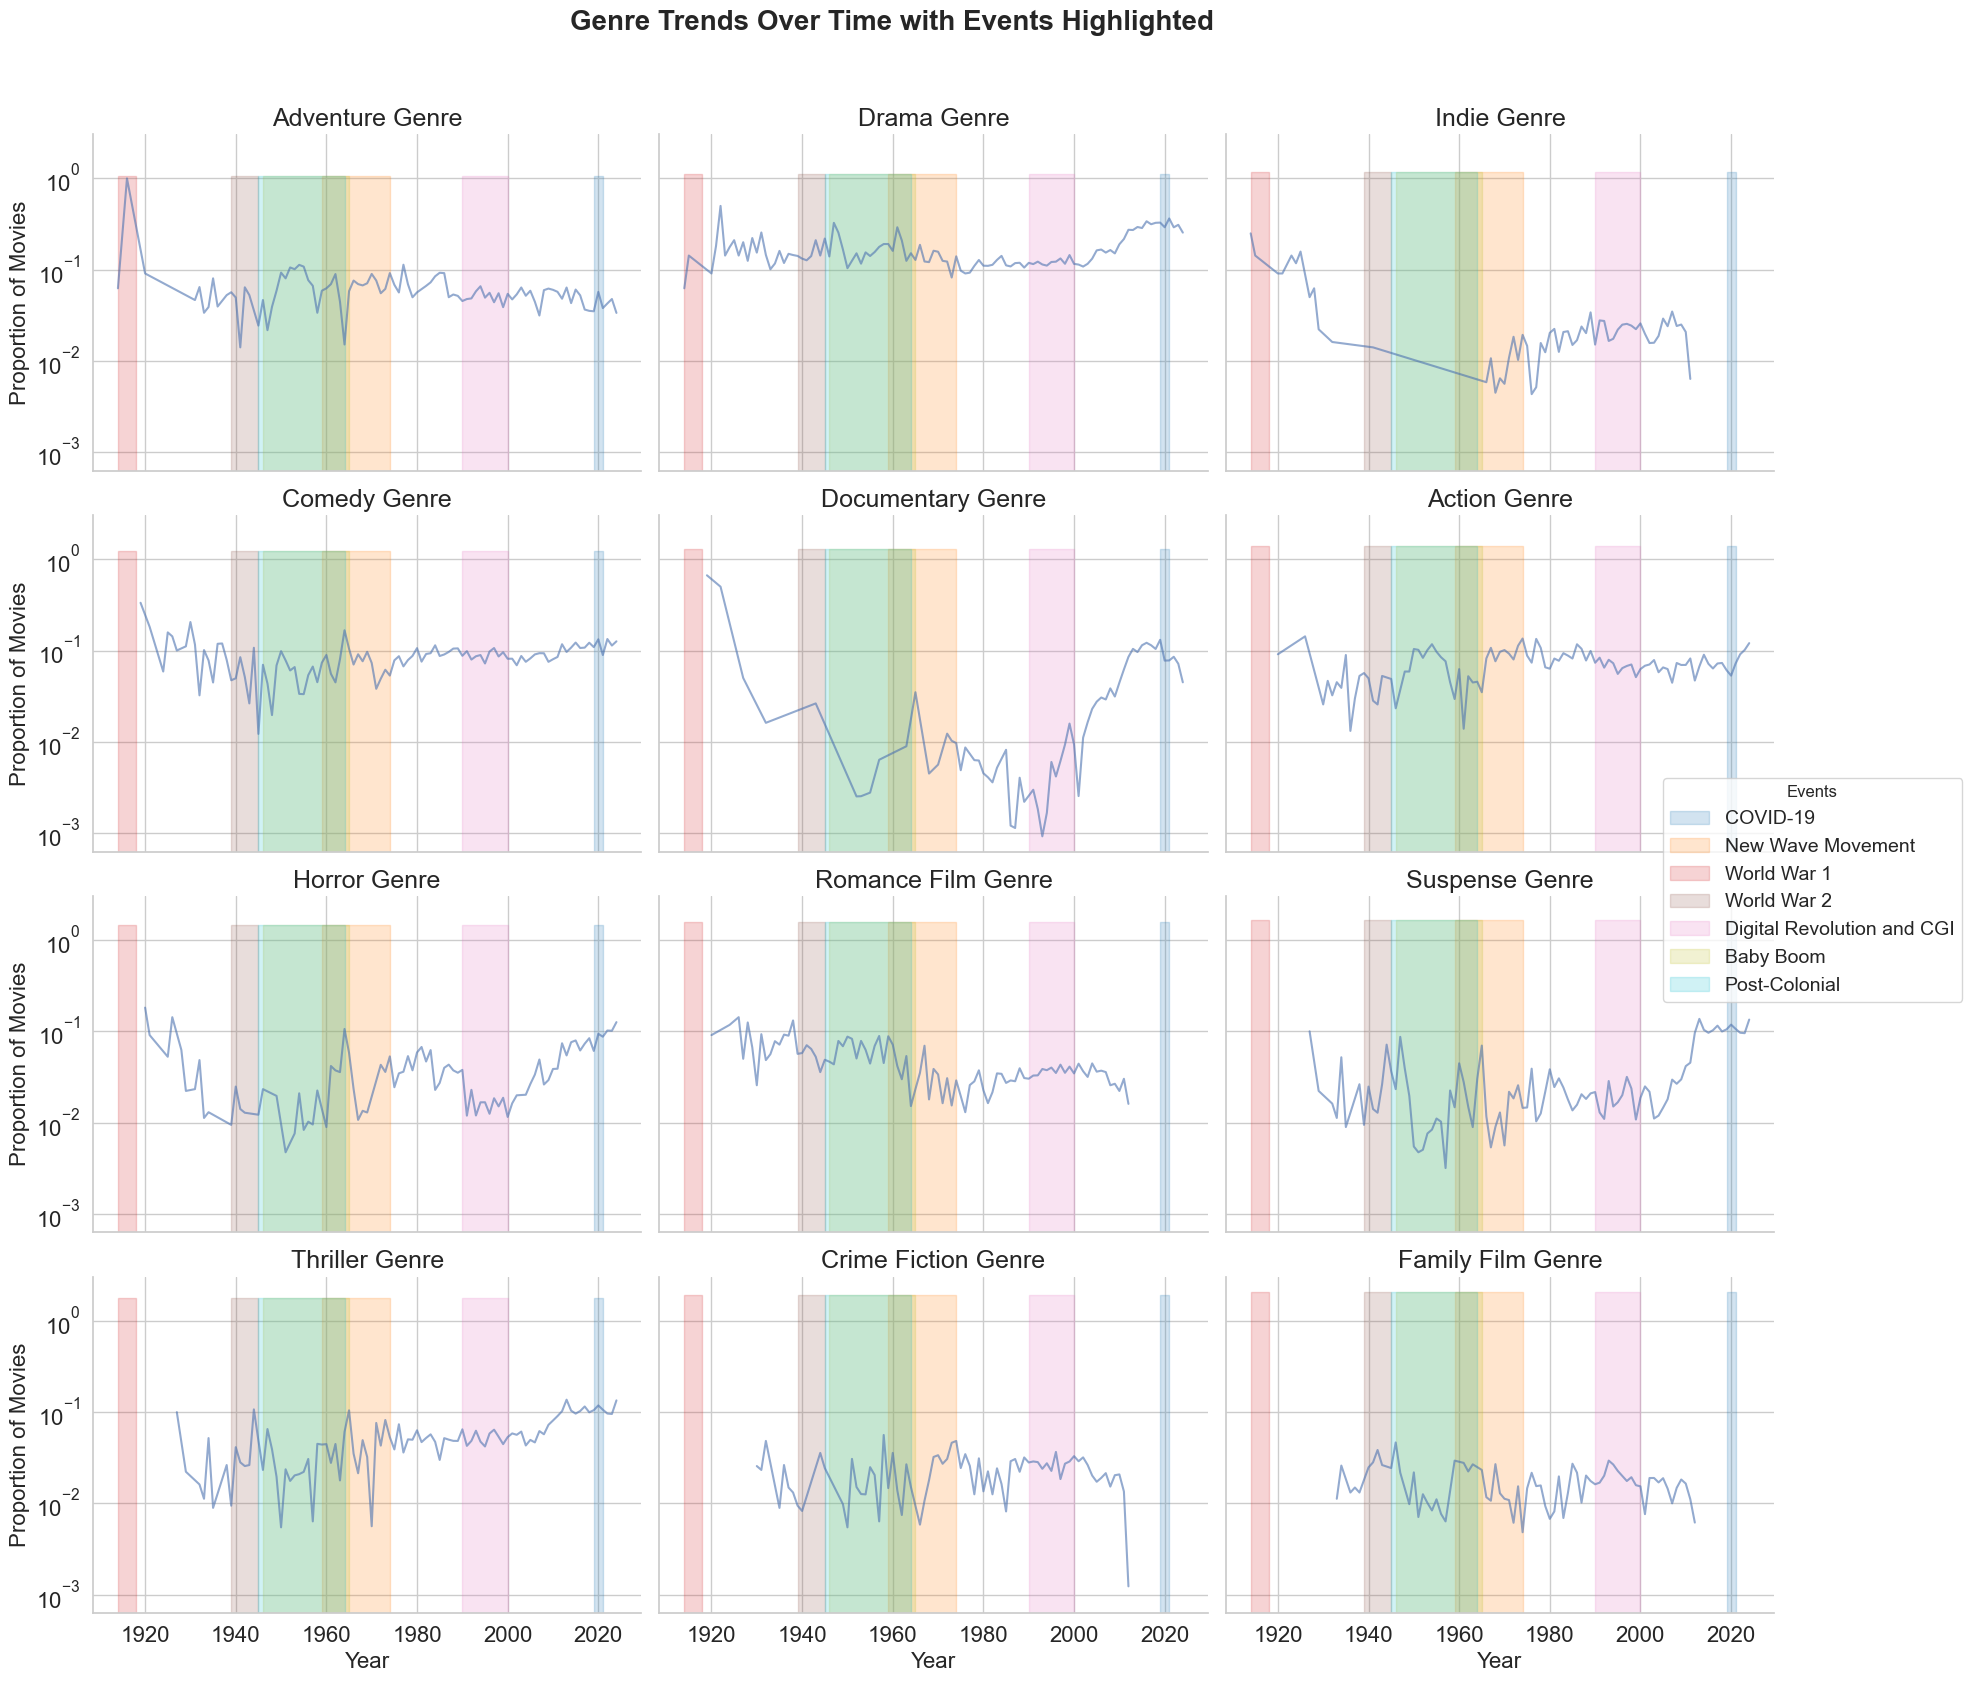

In [18]:
# Preprocess the data for the plot
genre_trends_top = preprocess_movies_for_genres_analysis_second_plot(df_movies)

event_names = events_df['Event'].unique()
color_map = cm.get_cmap('tab10', len(event_names)) 
event_colors = {event: mcolors.to_hex(color_map(i)) for i, event in enumerate(event_names)}

# Initialize the grid
g = sns.FacetGrid(genre_trends_top, col="Genre", col_wrap=3, height=4, aspect=1.5)

# Map lineplot for each genre
g.map(sns.lineplot, "Year", "Proportion", alpha=0.6)

# Overlay shaded regions for events
for ax in g.axes.flat:
    original_ylim = ax.get_ylim() 
    for _, row in events_df.iterrows():
        ax.fill_betweenx(
            original_ylim, 
            row['StartYear'], row['EndYear'],
            alpha=0.2, color=event_colors[row['Event']], label=row['Event']
        )

# Customize the appearance
g.set_titles("{col_name} Genre", size=18) 
g.set_axis_labels("Year", "Proportion of Movies", fontsize=16)

for ax in g.axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=16) 

g.tight_layout()

# Add a legend for the events
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(
    handles, labels, loc='center right', title="Events", bbox_to_anchor=(1.1, 0.5),
    fontsize=14, title_fontsize=12 
)

g.set(yscale="log")

g.fig.suptitle("Genre Trends Over Time with Events Highlighted", 
               fontsize=20, weight='bold', y=1.05)

# Show the plot
plt.show()

As we can see in the plot, during and after World War II, there was a marked increase in Documentaries and War Dramas, as filmmakers sought to document and process the difficulties of the era. These genres captured the collective need to reflect on and make sense of a rapidly changing world. In the Baby Boom era, Comedy and Family Films grew in popularity, providing audiences with lighthearted escapism during a time of optimism and domestic stability. The 1960s brought the New Wave Movement, a period of artistic experimentation that saw the rise of Drama and Crime Fiction, as directors pushed boundaries and redefined cinematic storytelling. The rise of the Digital Revolution in the 2000s marked another turning point, with technological advancements in CGI fueling the dominance of Action and Adventure films, genres that continue to command international appeal. Most recently, the COVID-19 pandemic brought its own influence, leading to a resurgence of Documentaries and Horror.